In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision, torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets

In [9]:
### chargons le datasets de MNIST à partir de la bibliothèque torchvision.dataset.MNIST

### train and test
train_data = datasets.MNIST(
    root = 'data',
    #shuffle = True,
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [10]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [11]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

Text(0.5, 1.0, '5')

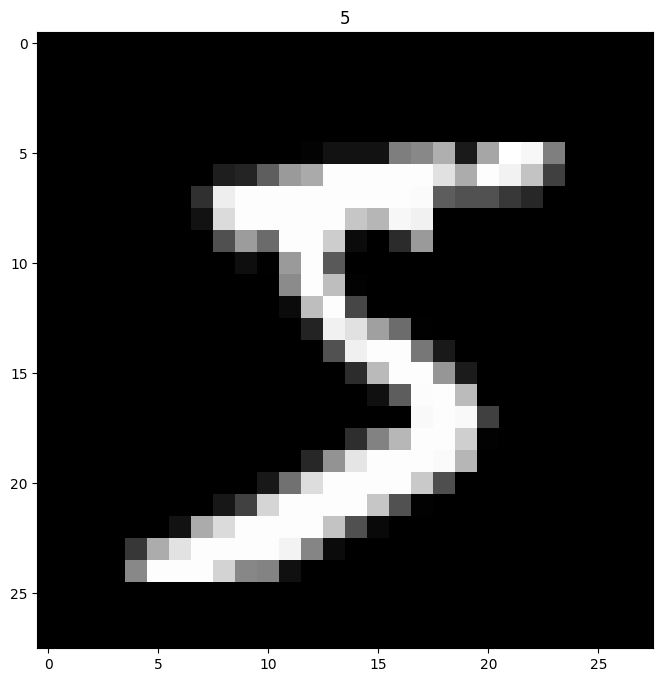

In [13]:
### visualize
img, label = train_data[0]

plt.figure(figsize =(8, 8))
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(label)

In [14]:
train_data.data.shape, train_data.targets.shape, test_data.data.shape, test_data.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [15]:
img.shape

torch.Size([1, 28, 28])

In [16]:
classes_name = train_data.classes
classes_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

<ipython-input-24-532726c0e02f>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, i)


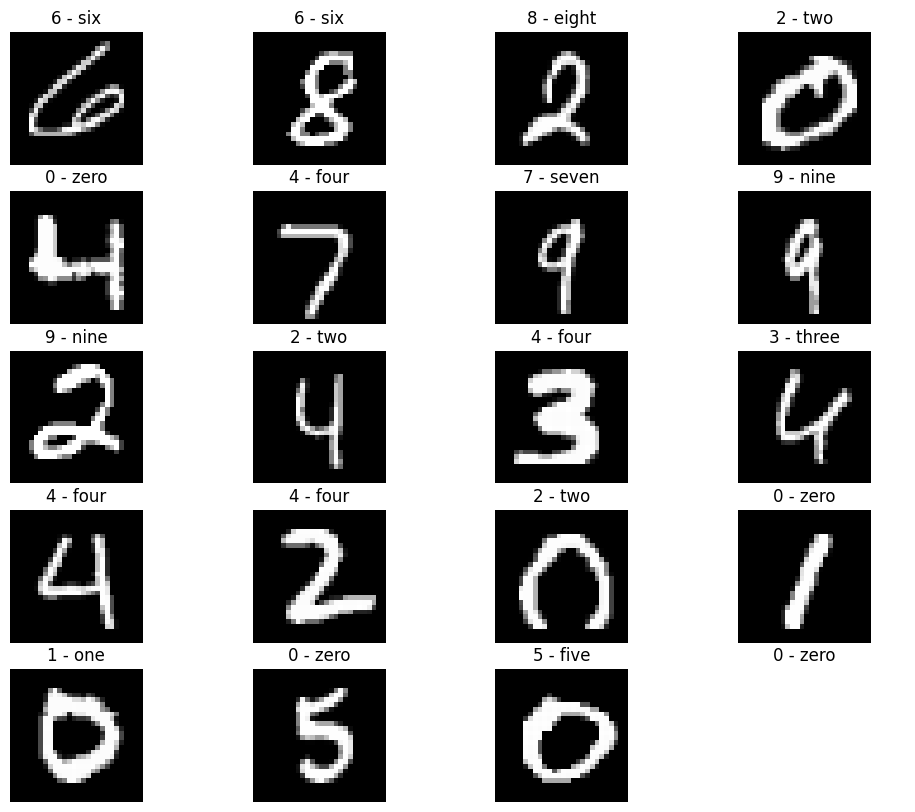

In [24]:
### visualizing the five images in train data
torch.manual_seed(42)
plt.figure(figsize = (12, 10))
rows, cols = 5, 4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(train_data),size  = [1]).item()
  img, label = train_data[random_idx]
  plt.imshow(img.squeeze(), cmap ='gray')
  plt.subplot(rows, cols, i)
  plt.axis('off')
  plt.title(classes_name[label])

In [25]:
### preparing the data loader
train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False
)

In [36]:
### building the model
class DigitsModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features  = output_shape)
    )
  def forward(self, x= torch.Tensor):
    x = self.linear_stack(x)
    return x

In [37]:
modelV1 = DigitsModel(input_shape =28*28 ,
                      hidden_units = 10,
                      output_shape = len(classes_name))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
modelV1.to(device)

DigitsModel(
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [38]:
modelV1.state_dict()

OrderedDict([('linear_stack.1.weight',
              tensor([[-0.0084,  0.0082, -0.0323,  ...,  0.0077, -0.0203,  0.0102],
                      [ 0.0293, -0.0189,  0.0286,  ..., -0.0213,  0.0093,  0.0127],
                      [-0.0102, -0.0030,  0.0247,  ..., -0.0097, -0.0306,  0.0286],
                      ...,
                      [-0.0206, -0.0286, -0.0236,  ..., -0.0284, -0.0078, -0.0352],
                      [-0.0330,  0.0263, -0.0211,  ...,  0.0081, -0.0187,  0.0057],
                      [-0.0024,  0.0133, -0.0047,  ..., -0.0058, -0.0352, -0.0177]])),
             ('linear_stack.1.bias',
              tensor([-0.0038, -0.0135,  0.0147,  0.0004,  0.0070,  0.0105,  0.0086, -0.0350,
                       0.0072,  0.0294])),
             ('linear_stack.3.weight',
              tensor([[ 0.1067,  0.2270, -0.1712, -0.0803, -0.2885, -0.2888, -0.2384,  0.1616,
                       -0.1860,  0.1061],
                      [ 0.2190,  0.1129, -0.1325,  0.2020,  0.1160,  0.0717, 

In [52]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = modelV1.parameters(), lr = 0.1)

In [43]:
!pip install torchmetrics
from tqdm import tqdm
from torchmetrics import Accuracy

accuracy = Accuracy(task = "multiclass", num_classes = len(classes_name)).to(device)

In [53]:
#### Training and testing loop

def training_step(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_function: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  accuracy_fn,
                  device: torch.device= device):
  train_loss, train_acc =0, 0
  for batch, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    model.train()
    ### predictions
    y_pred = model(x)
    ##" loss function"
    loss_train = loss_function(y_pred, y)
    train_loss += loss_train
    train_acc += accuracy_fn(y, y_pred.argmax(dim = 1))
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
  ### divided train_loss, train_acc by len(dataloader)
  train_loss /= len(data_loader)
  train_acc /=len(data_loader)
  print(f"Train loss:{train_loss: .5f} | Train acc: {train_acc: .5f}")

def testing_step(model: torch.nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_function: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 accuracy_fn,
                 device: torch.device = device
                 ):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x, y in data_loader:
      x, y =  x.to(device), y.to(device)
      test_pred = model(x)
      test_loss += loss_function(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim = 1))
    test_loss /=len(data_loader)
    test_acc /=len(data_loader)
    print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .5f}")

In [54]:
torch.manual_seed(42)
epochs = 6

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  training_step(model = modelV1,
                data_loader = train_dataloader,
                loss_function = loss_function,
                optimizer = optimizer,
                accuracy_fn = accuracy)
  testing_step(model = modelV1,
                data_loader = test_dataloader,
                loss_function = loss_function,
                optimizer = optimizer,
                accuracy_fn = accuracy)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30219 | Train acc:  0.10992


 17%|█▋        | 1/6 [00:13<01:09, 13.88s/it]

Test loss:  2.30143 | Test acc:  0.11352
Epoch: 1
---------
Train loss: 2.30182 | Train acc:  0.11058


 33%|███▎      | 2/6 [00:27<00:54, 13.65s/it]

Test loss:  2.30217 | Test acc:  0.11352
Epoch: 2
---------
Train loss: 2.30185 | Train acc:  0.11158


 50%|█████     | 3/6 [00:40<00:40, 13.59s/it]

Test loss:  2.30191 | Test acc:  0.11352
Epoch: 3
---------
Train loss: 2.30203 | Train acc:  0.11117


 67%|██████▋   | 4/6 [00:54<00:27, 13.53s/it]

Test loss:  2.30121 | Test acc:  0.11352
Epoch: 4
---------
Train loss: 2.30193 | Train acc:  0.11088


 83%|████████▎ | 5/6 [01:10<00:14, 14.33s/it]

Test loss:  2.30131 | Test acc:  0.11352
Epoch: 5
---------
Train loss: 2.30200 | Train acc:  0.11127


100%|██████████| 6/6 [01:23<00:00, 13.92s/it]

Test loss:  2.30156 | Test acc:  0.11352


In [55]:
def evaluate_model(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_function: torch.nn.Module,
                  accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  for x, y in data_loader:
    y_pred = model(x)
    loss += loss_function(y_pred, y)
    acc += accuracy_fn(y, y_pred.argmax(dim = 1))
  loss /= len(data_loader)
  acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [56]:
result_model_1 = evaluate_model(
    modelV1,
    test_dataloader,
    loss_function,
    accuracy
)
result_model_1

{'model_name': 'DigitsModel',
 'model_loss': 2.301555871963501,
 'model_acc': tensor(0.1135)}

In [64]:
### building the model with convolutionnal neural networks

class DigitsModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels =  input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,out_features = output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

modelV2 = DigitsModelV2(input_shape = 1,
                        hidden_units = 10,
                        output_shape = len(classes_name))
modelV2.to(device)

DigitsModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [65]:
### training and testing loop
torch.manual_seed(42)
epochs = 6

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  training_step(model = modelV2,
                data_loader = train_dataloader,
                loss_function = loss_function,
                optimizer = optimizer,
                accuracy_fn = accuracy)
  testing_step(model = modelV2,
               data_loader = test_dataloader,
               loss_function = loss_function,
               optimizer  = optimizer,
               accuracy_fn = accuracy)
  ### result model
result_modelV2 = evaluate_model(
    modelV2,
    test_dataloader,
    loss_function,
    accuracy
)
result_modelV2

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30280 | Train acc:  0.09868


 17%|█▋        | 1/6 [01:00<05:00, 60.06s/it]

Test loss:  2.30283 | Test acc:  0.09794
Epoch: 1
---------
Train loss: 2.30280 | Train acc:  0.09868


 33%|███▎      | 2/6 [02:01<04:04, 61.06s/it]

Test loss:  2.30283 | Test acc:  0.09794
Epoch: 2
---------
Train loss: 2.30280 | Train acc:  0.09868


 50%|█████     | 3/6 [03:01<03:00, 60.30s/it]

Test loss:  2.30283 | Test acc:  0.09794
Epoch: 3
---------
Train loss: 2.30280 | Train acc:  0.09868


 67%|██████▋   | 4/6 [04:01<02:00, 60.27s/it]

Test loss:  2.30283 | Test acc:  0.09794
Epoch: 4
---------
Train loss: 2.30280 | Train acc:  0.09868


 83%|████████▎ | 5/6 [05:02<01:00, 60.67s/it]

Test loss:  2.30283 | Test acc:  0.09794
Epoch: 5
---------
Train loss: 2.30280 | Train acc:  0.09868


100%|██████████| 6/6 [06:03<00:00, 60.66s/it]

Test loss:  2.30283 | Test acc:  0.09794


{'model_name': 'DigitsModelV2',
 'model_loss': 2.3028292655944824,
 'model_acc': tensor(0.0979)}